<a href="https://colab.research.google.com/github/angkmfirefoxygal/CIFAR10_CNN/blob/main/CIFAR10_Classification_withReg%26NoDropout_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [49]:
#정규화 방식 정의
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))] #.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
# )

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 학습용 데이터 불러오기
dataset = torchvision.datasets.CIFAR10(root = './data', train=True, download=True, transform = transform) #dataset = 5만개
trainset, valset = torch.utils.data.random_split(dataset, [30000,20000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

#테스트용 데이터 불러오기
testset = torchvision.datasets.CIFAR10(root ='./data', train=False, download=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)


# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


Files already downloaded and verified
Files already downloaded and verified


In [50]:
print(len(trainloader.dataset))
print(len(valloader.dataset))

30000
20000


In [51]:
def validation_loss(dataloader):
  n = len(dataloader)
  running_loss = 0

  with torch.no_grad():   #평가만 하기 때문에 requires_grad 비활성화
    resnet.eval()  #정규화 기법들이 작동하지 않도록 eval 모드로 설정
    for data in dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = resnet(images)
      loss= criterion(outputs, labels)
      running_loss += loss.item()

    resnet.train()  #모델을 다시 train 모드로 변경

    return running_loss/n

In [52]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels))

        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(self.out_channels))

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)

        out = F.relu(x + out)
        return out
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.gap = nn.AvgPool2d(4) # 4: 필터 사이즈
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):

        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def modeltype(model):
    if model == 'resnet18':
        return ResNet([2, 2, 2, 2])

    elif model == 'resnet34':
        return ResNet([3, 4, 6, 3])
resnet = modeltype('resnet18').to(device)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=0)

In [54]:
train_loss_list = []
val_loss_list = []
n = len(trainloader) # 매 에폭마다 평균 loss 값 계산 위해서
early_stopping_loss = 1 # 가장 낮은 loss 함수 값에 해당하는 모델 저장 위해서, 초기 기준 1로 설정
#배치 데이터 받아서 학습 진행
for epoch in range(30):
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    #배치 완료할 때 마다 평균 loss 값 계산
    train_loss = running_loss / n
    train_loss_list.append(train_loss)
    val_loss = validation_loss(valloader)
    val_loss_list.append(val_loss)

    print('[%d] train loss : %.3f, validation loss : %.3f' %(epoch +1, train_loss, val_loss))

    #현재 val 에서 loss 값이 기준보다 작으면 모델 저장 (train, val의 loss 함수 값과 에폭)
    if val_loss < early_stopping_loss:
        # torch.save(resnet.state_dict(), PATH)
        early_stopping_train_loss = train_loss
        early_stopping_val_loss = val_loss
        early_stopping_epoch = epoch

#학습 끝나면 조기종료한 에폭과 손실함수 값 출력
# print('Final pretrained model >> [%d] train loss: %.3f , validation loss: %.3f' %(early_stopping_epoch + 1,
#                                                         early_stopping_train_loss, early_stopping_val_loss))


[1] train loss : 1.681, validation loss : 1.387
[2] train loss : 1.296, validation loss : 1.177
[3] train loss : 1.095, validation loss : 1.028
[4] train loss : 0.993, validation loss : 0.956
[5] train loss : 0.889, validation loss : 0.861
[6] train loss : 0.796, validation loss : 0.867
[7] train loss : 0.720, validation loss : 0.730
[8] train loss : 0.658, validation loss : 0.673
[9] train loss : 0.615, validation loss : 0.629
[10] train loss : 0.566, validation loss : 0.575
[11] train loss : 0.529, validation loss : 0.610
[12] train loss : 0.499, validation loss : 0.574
[13] train loss : 0.472, validation loss : 0.554
[14] train loss : 0.445, validation loss : 0.523
[15] train loss : 0.426, validation loss : 0.501
[16] train loss : 0.404, validation loss : 0.497
[17] train loss : 0.382, validation loss : 0.516
[18] train loss : 0.365, validation loss : 0.484
[19] train loss : 0.341, validation loss : 0.463
[20] train loss : 0.326, validation loss : 0.483
[21] train loss : 0.310, vali

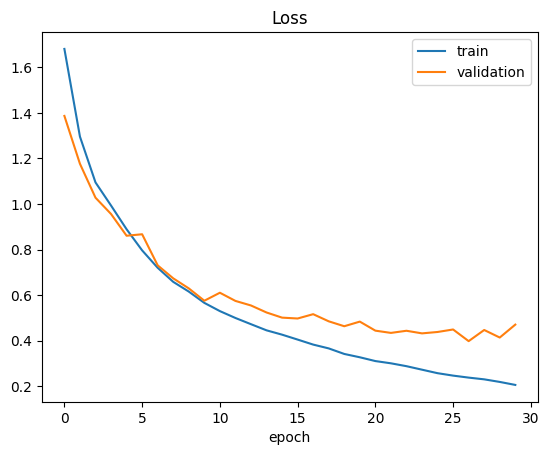

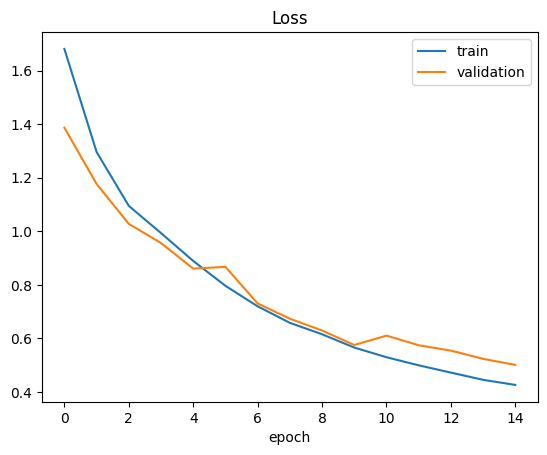

In [55]:
#loss plot 그리기
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train','validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

plt.plot(train_loss_list[:15])
plt.plot(val_loss_list[:15])
plt.legend(['train','validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

In [56]:
#Test set 예측
# 평가 데이터로 예측 실시해서 정확도 확인
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    resnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('Test accuracy: %.2f %%' % (100 * correct / total))


Test accuracy: 85.64 %


In [ ]:
correct = 0
total = 0
net = ResNet.to(device)

for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))